<a href="https://colab.research.google.com/github/drscook/m5364_23sp_data_science1/blob/main/pipelines_AirBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q 'git+https://github.com/drscook/helpers'
! pip install -q --upgrade pandas scikit-learn # pandas 2.0 just released on April 6
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.0 which is incompatible.


In [1]:
%reload_ext autotime
from helpers.common_imports import *
from helpers import utilities as ut
pd.DataFrame.prep = ut.prep  # add prep from my utilities to all dataframes (This is called "monkey patching". It's often considered poor practice compared to subclassing. But I find this one really convenient.)

# ask scikit-learn to give us pands dataframes rather than numpy arrays
from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.datasets import fetch_openml
airbnb = fetch_openml(data_id=43819)
df = airbnb.data.prep().set_index('id')

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<Axes: >

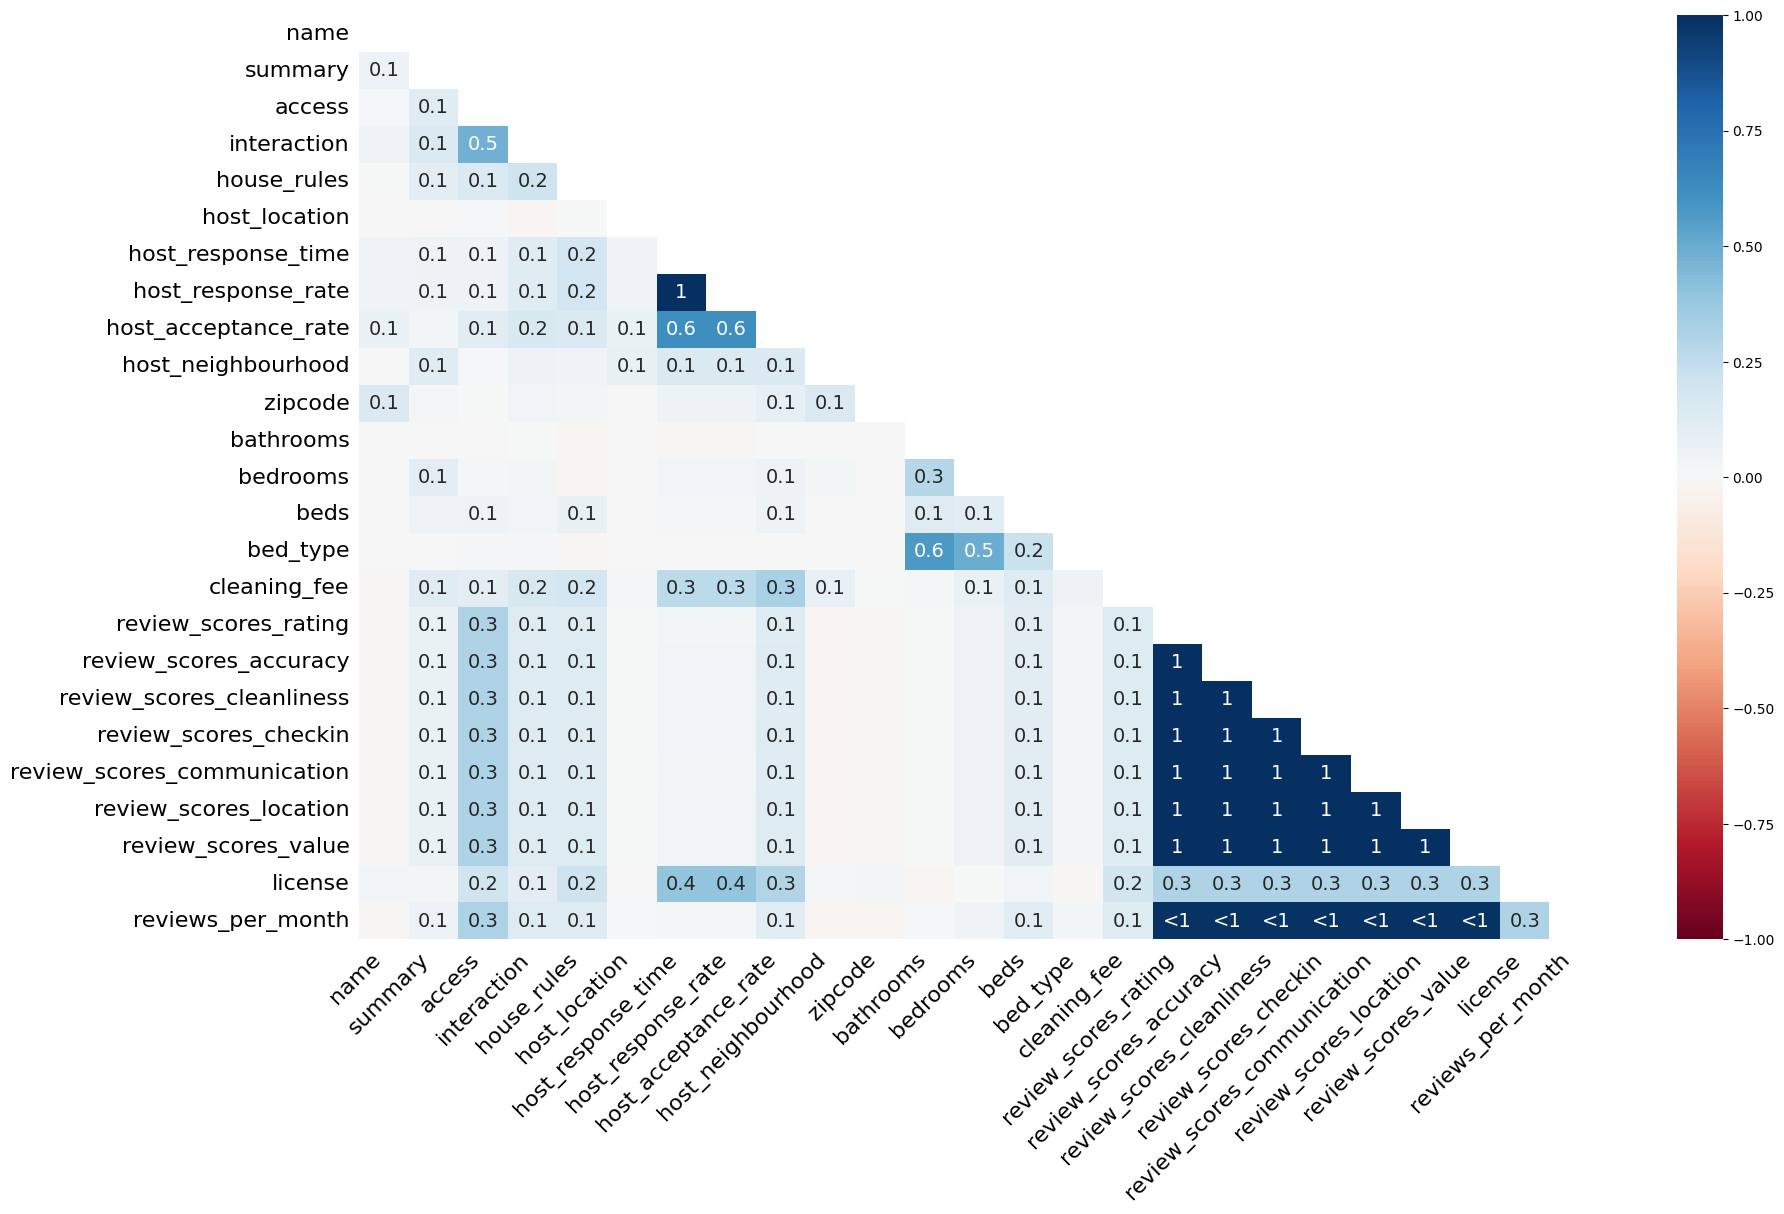

In [2]:
import missingno as msno
msno.heatmap(df)

In [62]:
# lower case all strings
for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass
df['pets_ok'] = ~df['house_rules'].str.contains('no pets')
df['smoking_ok'] = ~df['house_rules'].str.contains('smok')

# I tried to be more careful with smoking_ok, but there are a lot of different ways to say do not smoke here
# https://stackoverflow.com/questions/48541444/pandas-filtering-for-multiple-substrings-in-series/48600345#48600345
# df['smoking_ok'] = ~df['house_rules'].str.contains('|'.join(['smoking', 'non smoking', 'non-smoking', 'smoking not permitted', 'smoking is not permitted']))

In [63]:
df['smoking_ok'].value_counts(dropna=False)

smoking_ok
False    1451
True     1404
<NA>      990
Name: count, dtype: Int64

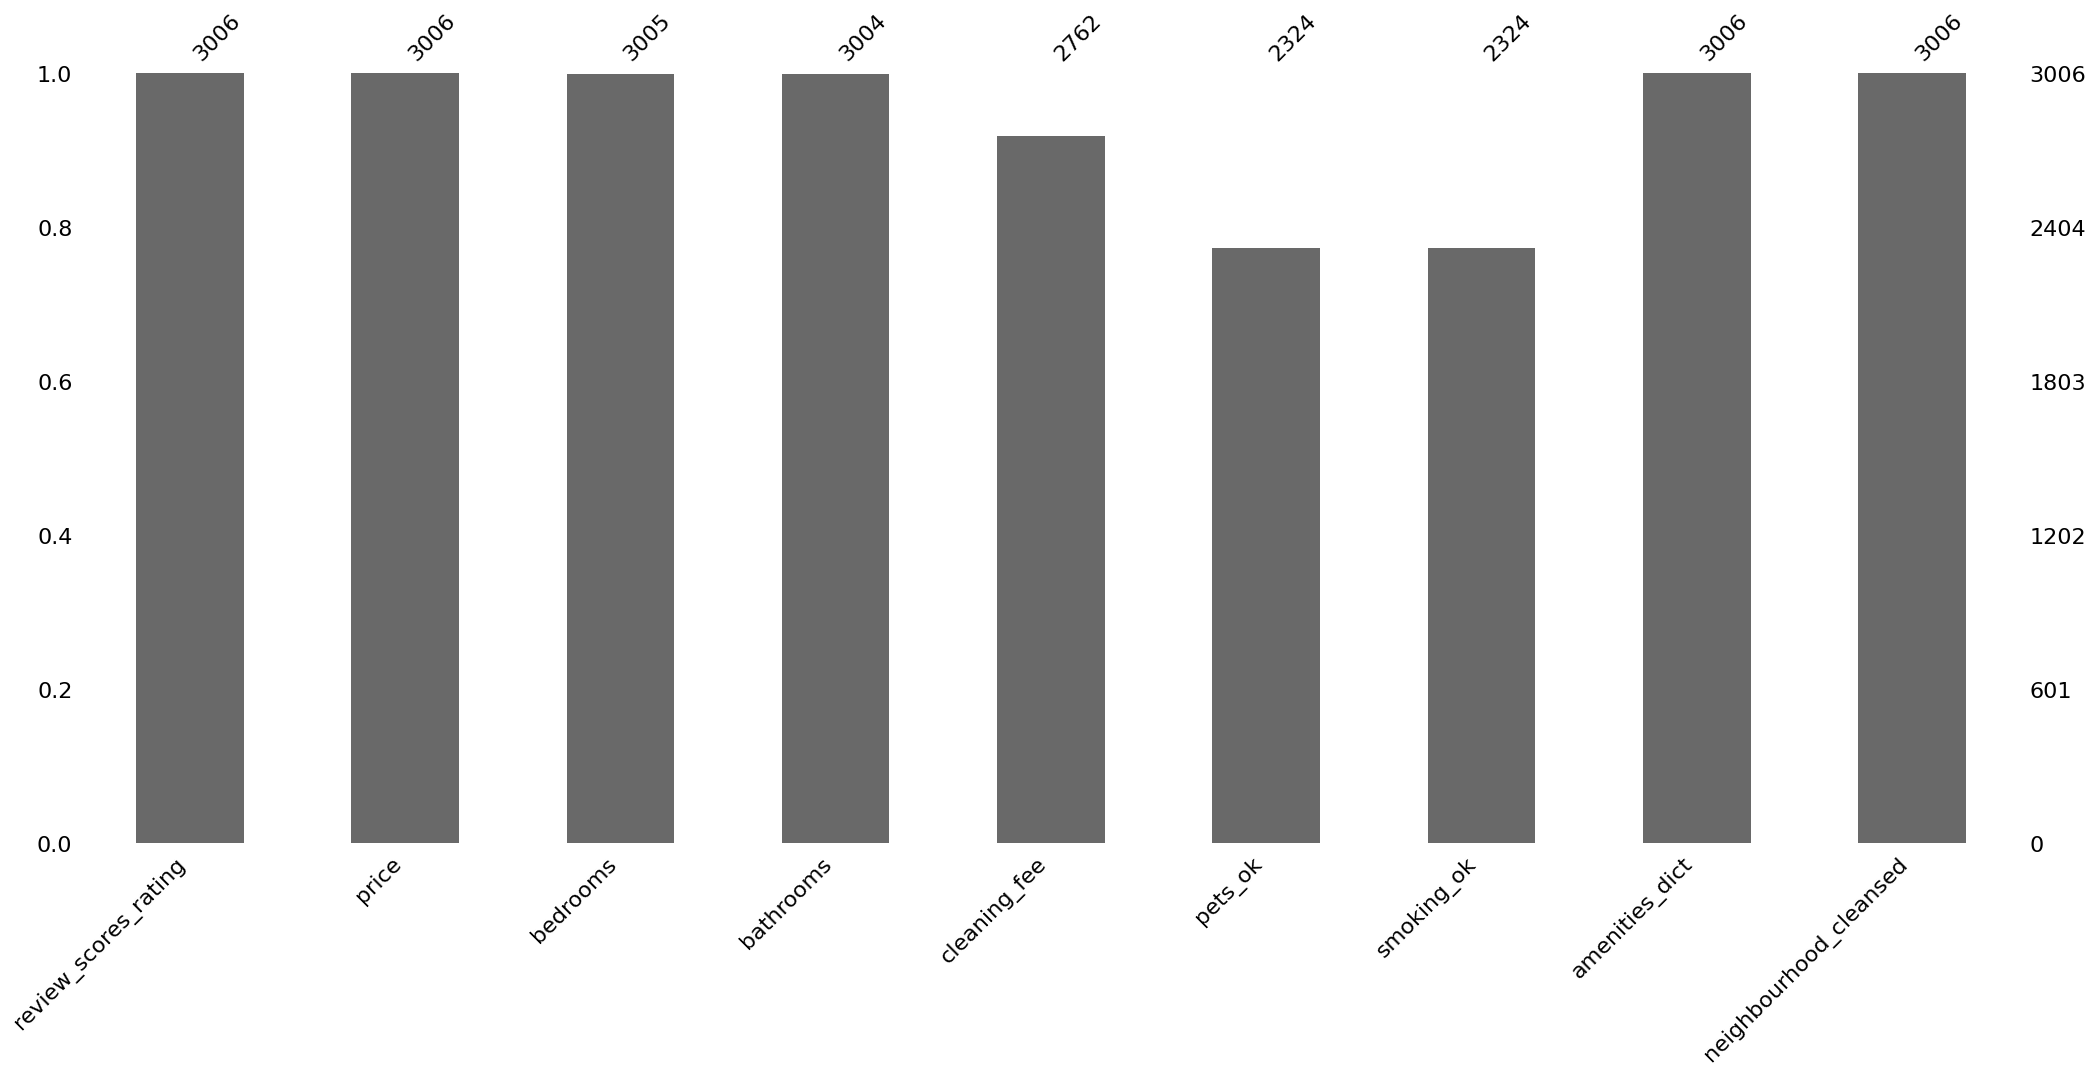

In [68]:
targ = 'review_scores_rating'
feat = [
    'price',
    'bedrooms',
    'bathrooms',
    'cleaning_fee',
    'pets_ok',
    'smoking_ok',
    'amenities_dict',
    'neighbourhood_cleansed',
]
all = [targ, *feat]
mask = df[targ].notnull()
df_all = df.loc[mask, all]

msno.bar(df_all)
display(df_all.describe(include='all'))
X = df_all[feat].copy()
y = df_all[targ].copy()



In [69]:
from sklearn.preprocessing import OneHotEncoder

# extract amenities into indicator columns
A = X['amenities_dict'].str.split(', ', expand=True)  # split pieces of amentities string into separate columns
A.columns = [x.split(':')[0].strip("'") for x in A.iloc[0]]  # assign columns names using row 0
A = A.apply(lambda x:x.str[-1] == '1').astype('boolean')#.prep()  # replace with True if the final character is 1

# can we use the neighborhood column?
enc = OneHotEncoder(sparse_output=False)  # one-hot encoder object
N = enc.fit_transform(X[['neighbourhood_cleansed']]).astype('boolean').prep()  # apply object to neighborhood_cleansed column
N.columns = N.columns.str[23:]  # assigns columns names of the form "neighborhood_cleansed_neighborhood name". It's often useful to have the original column name first, but not here. So we remove it.
X = X.join(N).join(A).drop(columns=['amenities_dict', 'neighbourhood_cleansed']).prep()  # join and drop original columns
X.head(3)
# N

,price,bedrooms,bathrooms,cleaning_fee,pets_ok,smoking_ok,allston,back bay,bay village,beacon hill,brighton,charlestown,chinatown,dorchester,downtown,east boston,fenway,hyde park,jamaica plain,leather district,longwood medical area,mattapan,mission hill,north end,roslindale,roxbury,south boston,south boston waterfront,south end,west end,west roxbury,tv,cable tv,wifi,air conditioning,kitchen,free parking on premises,free street parking,heating,washer,dryer,smoke detector,carbon monoxide detector,essentials,shampoo,24-hour check-in,hangers,hair dryer,iron,laptop friendly workspace,hot water,bed linens,extra pillows and blankets,microwave,coffee maker,refrigerator,dishwasher,dishes and silverware,cooking basics,oven,stove,patio or balcony,internet,family/kid friendly,first aid kit,fire extinguisher,lock on bedroom door,self check-in,keypad,private entrance,bathtub,luggage dropoff allowed,long term stays allowed,paid parking off premises,doorman,elevator,other,ethernet connection,lockbox,,pets allowed,buzzer/wireless intercom,smart lock,pack n play/travel crib,host greets you,breakfast,private living room,waterfront,indoor fireplace,garden or backyard,pets live on this property,dog(s),wide entrance for guests,well-lit path to entrance,cat(s),smoking allowed,safety card,hot tub,pool,childrens books and toys,babysitter recommendations,game console,bbq grill,single level home,cleaning before checkout,lake access,trash can,beach essentials,firm mattress,other pet(s),outlet covers,ev charger,paid parking on premises,no stairs or steps to enter,flat path to guest entrance,room-darkening shades,baking sheet,barbecue utensils,hot water kettle,building staff,suitable for events,shower gel,high chair,childrens dinnerware,gym,window guards,crib,beachfront,wheelchair accessible,changing table,pocket wifi,baby bath,stair gates,fireplace guards,baby monitor,bread maker,wide hallways,disabled parking spot,bathtub with bath chair,shower chair,private bathroom,table corner guards,extra space around bed,ski-in/ski-out,snacks,bottled water,accessible-height bed,accessible-height toilet,handheld shower head,fixed grab bars for shower,fixed grab bars for toilet,wide clearance to shower,toilet,body soap,bath towel,toilet paper,safe,bedroom comforts,bathroom essentials,game room,luggage storage,front desk,self parking,concierge
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3781,125.00,1,1.0,75,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5506,145.00,1,1.0,60,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [74]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

amenity_feat = A.columns
amenity_preproc = Pipeline(
    steps=[
        ('pca', PCA)
    ]
)

numeric_feat = ['price', 'bedrooms', 'bathrooms', 'cleaning fee', 'pets_ok', 'smoking_ok']
numeric_preproc = Pipeline(
    steps=[
        ('scaler', MinMaxScaler),
        ('imputer', KNNImputer),
    ]
)


preproc = ColumnTransformer(
    transformers = [
        ('amenities', amenity_feat, amenity_preproc),
        ('numeric'  , numeric_feat, amenity_preproc),
    ]
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor